Average relative error for GUS: 0.42608605722683024
Average relative error for GEM5: 0.5378182281280905
Average MIPS for Gus: 2.7580808556196836
Average MIPS for Gemm: 0.26750552763558855


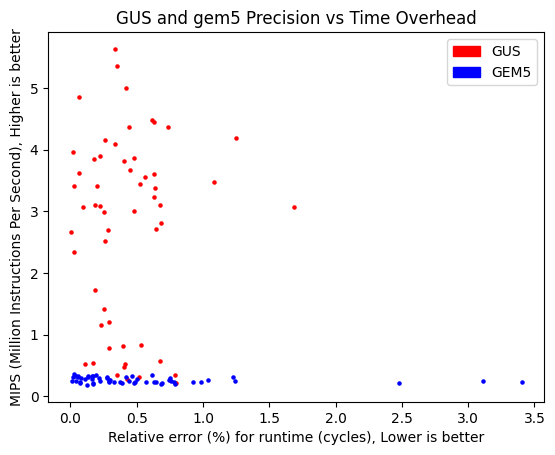

In [111]:
import os
import glob
import pandas as pd

benchmark_by_name_time = {}
benchmark_by_name_cycles = {}
benchmark_by_name_insns = {}
benchmark_by_name_uops_retired = {}
benchmark_by_name_precision_uops = {}
benchmark_by_name_precison = {}
benchmark_by_name_time_overheard = {}

def parse_papi_report(file) -> tuple[int, int]:
    with open(file, 'r') as f:
        lines = f.readlines()
        stats = []
        for line in lines:
            counters = line.split()
            tot_cyc, tot_ins, uops_retired = counters[3], counters[4], counters[5]
            stats.append([tot_cyc, tot_ins, uops_retired])
        df = pd.DataFrame(stats, columns=['tot_cyc', 'tot_ins', 'uops_retired'])
        return float(df['tot_cyc'].astype(int).mean()), float(df['uops_retired'].astype(int).mean()), 0., float(df['tot_ins'].astype(int).mean())
        

def parse_gus_report(file):
    instructions = None
    cycles = None
    exec_time_seconds = None
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if "EXECUTION TIME" in line:
                cycles = float(line.split()[3])
            if "gus_runtime_seconds" in line:
                exec_time_seconds = float(line.split()[1])
            if "NUMBER OF INSTRUCTIONS" in line:
                instructions = float(line.split()[4])

    d = {'cycles': cycles, 'exec_time_seconds': exec_time_seconds, 'uops_retired': None}
    return cycles, None, exec_time_seconds, instructions

def parse_gem5_report(dir):
    stats = []

    num_insts = None
    num_ops = None
    host_seconds = None
    num_cycles = None

    for file in glob.glob(dir + 'stats.txt'):
        with open(file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if "board.processor.cores.core.commitStats0.numInsts" in line:
                    num_insts = int(line.split()[1])
                if "board.processor.cores.core.commitStats0.numOps" in line:
                    num_ops = int(line.split()[1])
                if "hostSeconds" in line:
                    host_seconds = float(line.split()[1])
                if "board.processor.cores.core.numCycles" in line:
                    num_cycles = int(line.split()[1])

    d = {'uops_retired': num_ops, 'exec_time_seconds': host_seconds, 'cycles': num_cycles}
    return num_cycles, num_ops, host_seconds, num_insts

papi_files = glob.glob('papi_reports/*.papi_report')
for file in papi_files:
    file_name = os.path.basename(file)
    name_before_last_dot = file_name.split('.papi_report')[0]
    parse_papi_report(file)
    if name_before_last_dot not in benchmark_by_name_cycles:
        benchmark_by_name_cycles[name_before_last_dot] = {}
    if name_before_last_dot not in benchmark_by_name_time:
        benchmark_by_name_time[name_before_last_dot] = {}
    if name_before_last_dot not in benchmark_by_name_insns:
        benchmark_by_name_insns[name_before_last_dot] = {}
    if name_before_last_dot not in benchmark_by_name_uops_retired:
        benchmark_by_name_uops_retired[name_before_last_dot] = {}
    cycles, uops_retired, exec_time_seconds, insns = parse_papi_report(file)
    benchmark_by_name_cycles[name_before_last_dot]["papi"] = cycles
    benchmark_by_name_time[name_before_last_dot]["papi"] = exec_time_seconds
    benchmark_by_name_insns[name_before_last_dot]["papi"] = insns
    benchmark_by_name_uops_retired[name_before_last_dot]["papi"] = uops_retired

gus_reports = glob.glob('gus_reports3/*.gus_report')
for file in gus_reports:
    file_name = os.path.basename(file)
    name_before_last_dot = file_name.split('.gus_report')[0]
    if name_before_last_dot not in benchmark_by_name_cycles:
        benchmark_by_name_cycles[name_before_last_dot] = {}
    if name_before_last_dot not in benchmark_by_name_time:
        benchmark_by_name_time[name_before_last_dot] = {}
    if name_before_last_dot not in benchmark_by_name_insns:
        benchmark_by_name_insns[name_before_last_dot] = {}
    cycles, uops_retired, exec_time_seconds, insns = parse_gus_report(file)
    benchmark_by_name_cycles[name_before_last_dot]["gus"] = cycles
    benchmark_by_name_time[name_before_last_dot]["gus"] = exec_time_seconds
    benchmark_by_name_insns[name_before_last_dot]["gus"] = insns

gem5_reports = glob.glob('gem5_reports/*/')
for dir in gem5_reports:
    dir_name = os.path.basename(os.path.normpath(dir))
    if dir_name not in benchmark_by_name:
        benchmark_by_name[dir_name] = {}
    cycles, uops_retired, exec_time_seconds, insns = parse_gem5_report(dir)
    benchmark_by_name_cycles[dir_name]["gem5"] = cycles
    benchmark_by_name_time[dir_name]["gem5"] = exec_time_seconds
    benchmark_by_name_insns[dir_name]["gem5"] = insns
    benchmark_by_name_uops_retired[dir_name]["gem5"] = uops_retired

for benchmark in benchmark_by_name_cycles:
    if "papi" in benchmark_by_name_cycles[benchmark] and "gus" in benchmark_by_name_cycles[benchmark]:
        papi_cycles = benchmark_by_name_cycles[benchmark]["papi"]
        gus_cycles = benchmark_by_name_cycles[benchmark]["gus"]
        gem5_cycles = benchmark_by_name_cycles[benchmark]["gem5"]

        benchmark_by_name_precison[benchmark] = {}
        benchmark_by_name_precison[benchmark]["gus"] = abs(gus_cycles - papi_cycles) / papi_cycles
        benchmark_by_name_precison[benchmark]["gem5"] = abs(gem5_cycles - papi_cycles) / papi_cycles

for benchmark in benchmark_by_name_uops_retired:
    if "papi" in benchmark_by_name_uops_retired[benchmark] and "gem5" in benchmark_by_name_uops_retired[benchmark]:
        papi_uops_retired = benchmark_by_name_uops_retired[benchmark]["papi"]
        gem5_uops_retired = benchmark_by_name_uops_retired[benchmark]["gem5"]
        benchmark_by_name_precision_uops[benchmark] = {}
        benchmark_by_name_precision_uops[benchmark]["gem5"] = abs(gem5_uops_retired - papi_uops_retired) / papi_uops_retired

for benchmark in benchmark_by_name_time:
    if "papi" in benchmark_by_name_time[benchmark] and "gus" in benchmark_by_name_time[benchmark]:
        gus_time = benchmark_by_name_time[benchmark]["gus"]
        gem5_time = benchmark_by_name_time[benchmark]["gem5"]

        gus_insns = benchmark_by_name_insns[benchmark]["gus"]
        gem5_insns = benchmark_by_name_insns[benchmark]["gem5"]

        gus_insns_per_sec = gus_insns / gus_time
        gem5_insns_per_sec = gem5_insns / gem5_time

        gus_mips = gus_insns_per_sec / 1000000
        gem5_mips = gem5_insns_per_sec / 1000000

        benchmark_by_name_time_overheard[benchmark] = {}
        benchmark_by_name_time_overheard[benchmark]["gus"] = gus_mips
        benchmark_by_name_time_overheard[benchmark]["gem5"] = gem5_mips

import matplotlib.pyplot as plt
import numpy as np

x = []
y = []
labels = []

x_gem5 = []
y_gem5 = []
labels_gem5 = []


for benchmark in benchmark_by_name_precison:
    if "gus" in benchmark_by_name_precison[benchmark] and "gem5" in benchmark_by_name_precison[benchmark]:
        x.append(benchmark_by_name_precison[benchmark]["gus"])
        y.append(benchmark_by_name_time_overheard[benchmark]["gus"])
        labels.append(benchmark)

        x_gem5.append(benchmark_by_name_precison[benchmark]["gem5"])
        y_gem5.append(benchmark_by_name_time_overheard[benchmark]["gem5"])
        labels_gem5.append(benchmark)


fig, ax = plt.subplots()
ax.scatter(x, y, color='red', s=5)
ax.scatter(x_gem5, y_gem5, color='blue', s=5)

plt.xlabel('Relative error (%) for runtime (cycles), Lower is better')
plt.ylabel('MIPS (Million Instructions Per Second), Higher is better')
plt.title('GUS and gem5 Precision vs Time Overhead')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='GUS')
blue_patch = mpatches.Patch(color='blue', label='GEM5')
plt.legend(handles=[red_patch, blue_patch])

print("Average relative error for GUS:", np.mean(x))
print("Average relative error for GEM5:", np.mean(x_gem5))

print("Average MIPS for Gus:", np.mean(y))
print("Average MIPS for Gemm:", np.mean(y_gem5))



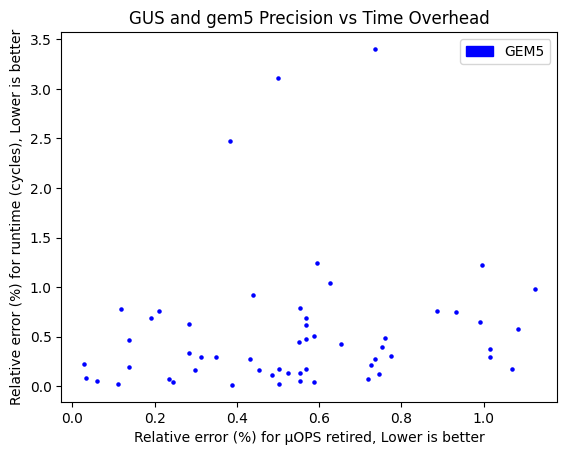

In [112]:
# plot precision on x-axis and time overhead on y-axis for gus and gem5 in a scatter plot
import matplotlib.pyplot as plt
import numpy as np

x = []
y = []
labels = []

x_gem5 = []
y_gem5 = []
labels_gem5 = []


for benchmark in benchmark_by_name_precison:
    if "gem5" in benchmark_by_name_precision_uops[benchmark]:
        x_gem5.append(benchmark_by_name_precision_uops[benchmark]["gem5"])
        y_gem5.append(benchmark_by_name_precison[benchmark]["gem5"])
        labels_gem5.append(benchmark)


fig, ax = plt.subplots()
# use different colors for gus and gem5 points
ax.scatter(x, y, color='red', s=5)
ax.scatter(x_gem5, y_gem5, color='blue', s=5)

# change dot size

plt.xlabel('Relative error (%) for µOPS retired, Lower is better')
plt.ylabel('Relative error (%) for runtime (cycles), Lower is better') 
plt.title('GUS and gem5 Precision vs Time Overhead')

# Add legends for colors
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='GEM5')
plt.legend(handles=[blue_patch])

